# Multiclass Support Vector Machine demo
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [3]:
# Run some setup code for this notebook
import random
import numpy as np
from models_utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [4]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape: ', X_train.shape
print 'Training labels shape: ', y_train.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


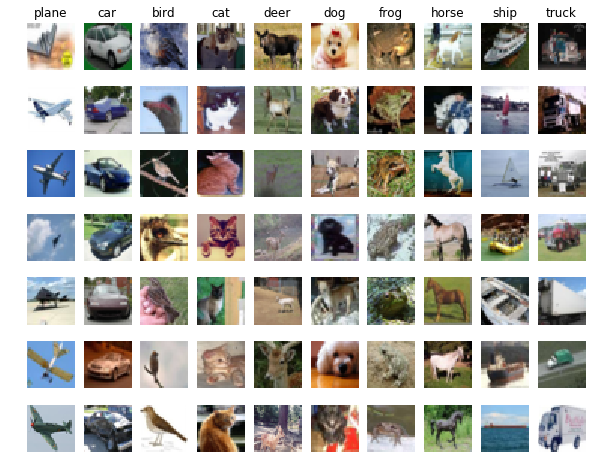

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print 'Training data shape: ', X_train.shape
print 'Validation data shape: ', X_val.shape
print 'Test data shape: ', X_test.shape
print 'dev data shape: ', X_dev.shape

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


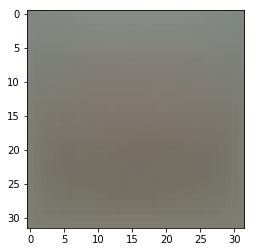

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print mean_image[:10] # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print X_train.shape, X_val.shape, X_test.shape, X_dev.shape

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

The code for this section will all be written inside **hw1/classifiers/linear_svm.py**. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from models_utils.classifiers.linear_svm import structured_loss_simple
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = structured_loss_simple(W, X_dev, y_dev, 0.00001)
print 'loss: %f' % (loss, )

loss: 9.240668


To check that we have implemented the gradient correctly, we can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that is computed.

In [14]:
# Compute the loss and its gradient at W.
loss, grad = structured_loss_simple(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from models_utils.gradient_check import grad_check_sparse
f = lambda w: structured_loss_simple(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
loss, grad = structured_loss_simple(W, X_dev, y_dev, 1e2)
f = lambda w: structured_loss_simple(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.191457 analytic: 4.191457, relative error: 1.576308e-11
numerical: -16.880372 analytic: -16.880372, relative error: 2.347528e-11
numerical: -8.978252 analytic: -8.978252, relative error: 9.418107e-12
numerical: 24.391965 analytic: 24.295712, relative error: 1.976953e-03
numerical: -1.095580 analytic: -1.095580, relative error: 4.302179e-10
numerical: -3.564208 analytic: -3.564208, relative error: 8.869578e-11
numerical: -3.900206 analytic: -3.900206, relative error: 1.982924e-13
numerical: 31.498640 analytic: 31.540260, relative error: 6.602400e-04
numerical: 28.114313 analytic: 28.030665, relative error: 1.489859e-03
numerical: 13.853766 analytic: 13.853766, relative error: 5.924303e-12
numerical: 6.929879 analytic: 6.929879, relative error: 2.400815e-11
numerical: 14.821029 analytic: 14.821029, relative error: 1.053743e-11
numerical: 1.602416 analytic: 1.569142, relative error: 1.049123e-02
numerical: 15.303276 analytic: 15.306653, relative error: 1.103296e-04
numerical:

### Note
SVM loss uses a hinge loss, instead of a square loss. There is a first order derivate discontinuity right at the point of +- margin (or more generally norm of the support vectors) 

In a 1-D case, a point right at the margin would not count towards loss or dW analytically but numerical gradient will give a non-zero value -- f(x,W+h)/h

In [19]:
tic = time.time()
_, grad_naive = structured_loss_simple(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Naive loss and gradient: computed in %fs' % (toc - tic)

tic = time.time()
_, grad_vectorized = structured_loss_fast(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'Vectorized loss and gradient: computed in %fs' % (toc - tic)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'difference: %f' % difference

Naive loss and gradient: computed in 0.193747s
Vectorized loss and gradient: computed in 0.010570s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [20]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from models_utils.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print 'That took %fs' % (toc - tic)

iteration 0 / 1500: loss 789.271979
iteration 100 / 1500: loss 775.211948
iteration 200 / 1500: loss 771.146661
iteration 300 / 1500: loss 767.559311
iteration 400 / 1500: loss 764.836719
iteration 500 / 1500: loss 761.548536
iteration 600 / 1500: loss 759.820131
iteration 700 / 1500: loss 758.100155
iteration 800 / 1500: loss 756.072073
iteration 900 / 1500: loss 754.697537
iteration 1000 / 1500: loss 753.617263
iteration 1100 / 1500: loss 751.528335
iteration 1200 / 1500: loss 749.075081
iteration 1300 / 1500: loss 746.489361
iteration 1400 / 1500: loss 746.043064
That took 6.111989s


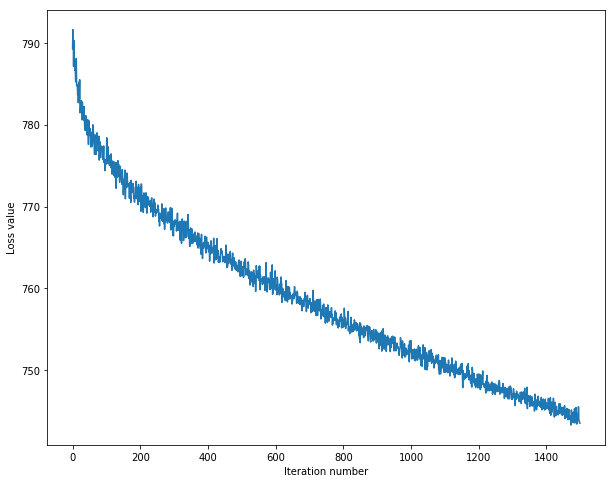

In [21]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
y_train_pred = svm.predict(X_train)
print 'training accuracy: %f' % (np.mean(y_train == y_train_pred), )
y_val_pred = svm.predict(X_val)
print 'validation accuracy: %f' % (np.mean(y_val == y_val_pred), )

training accuracy: 0.300980
validation accuracy: 0.306000


In [23]:
learning_rates = [7e-8, 1e-8, 1e-7, 1e-6]
regularization_strengths = [5e-1, 1e-2, 5, 1e3, 1e5, 1e6]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
best_params = None


for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        cv_svm = LinearSVM()
        loss_hist = cv_svm.train(X_train, y_train, learning_rate=learning_rate, 
                              reg=regularization_strength,
                              num_iters= 2000, verbose=False)
        y_train_pred = cv_svm.predict(X_train)
        y_val_pred   = cv_svm.predict(X_val)
        train_accuracy = np.mean(y_train_pred == y_train)
        cv_accuracy = np.mean(y_val_pred == y_val)
        
        results[(learning_rate, regularization_strength)] = (train_accuracy,cv_accuracy)
        
        if cv_accuracy > best_val:
            best_val = cv_accuracy
            best_svm = cv_svm
            best_params = (learning_rate, regularization_strength)

            
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

lr 1.000000e-08 reg 1.000000e-02 train accuracy: 0.229510 val accuracy: 0.231000
lr 1.000000e-08 reg 5.000000e-01 train accuracy: 0.235306 val accuracy: 0.244000
lr 1.000000e-08 reg 5.000000e+00 train accuracy: 0.227306 val accuracy: 0.220000
lr 1.000000e-08 reg 1.000000e+03 train accuracy: 0.237939 val accuracy: 0.228000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.234490 val accuracy: 0.237000
lr 1.000000e-08 reg 1.000000e+06 train accuracy: 0.233898 val accuracy: 0.250000
lr 7.000000e-08 reg 1.000000e-02 train accuracy: 0.298347 val accuracy: 0.357000
lr 7.000000e-08 reg 5.000000e-01 train accuracy: 0.303531 val accuracy: 0.317000
lr 7.000000e-08 reg 5.000000e+00 train accuracy: 0.300776 val accuracy: 0.308000
lr 7.000000e-08 reg 1.000000e+03 train accuracy: 0.305245 val accuracy: 0.301000
lr 7.000000e-08 reg 1.000000e+05 train accuracy: 0.298694 val accuracy: 0.309000
lr 7.000000e-08 reg 1.000000e+06 train accuracy: 0.305122 val accuracy: 0.320000
lr 1.000000e-07 reg 1.000000

In [25]:
# Train Best SVM further
best_svm.train(X_train, y_train, learning_rate=best_params[0], reg=best_params[1],
                num_iters=10000, verbose=False)

[3.6966645871526875,
 4.0167667839292109,
 5.1715856259520923,
 4.3976353976640139,
 3.3402336140617588,
 4.5455644917571671,
 5.1435132253311231,
 3.9671207545517402,
 4.0545199860360004,
 4.0517333459175457,
 5.086328508219836,
 4.5692134425203248,
 4.7359230676958157,
 5.3301843342562556,
 4.6401914359417189,
 4.2461322006362936,
 4.4588461453702042,
 5.2148792218665383,
 4.4402484136380762,
 3.9494886616956442,
 3.9317217170951175,
 4.0534151782022931,
 4.2298166459917503,
 4.6620201708654001,
 4.5304710012049823,
 4.4256074161369829,
 4.515183839890403,
 5.2014138728635517,
 3.9459753352494635,
 4.0185442776554243,
 4.4251210842224777,
 4.3099848858965775,
 4.4111918415058025,
 4.352967671284083,
 4.2263329559706309,
 4.1683909396961285,
 4.49153628036317,
 4.0442189523890839,
 3.9882155130128556,
 5.5222725590795658,
 4.1474311386070326,
 4.7135908048660085,
 4.3059000654841864,
 4.6303752959914855,
 5.2417881456825315,
 5.0426523136938108,
 3.5338185604393155,
 3.997713663043704

In [27]:
y_train_pred = best_svm.predict(X_train)
train_acc = np.mean(y_train == y_train_pred)
print 'training accuracy: %f' % (train_acc, )
y_val_pred = best_svm.predict(X_val)
val_acc = np.mean(y_val == y_val_pred)
print 'validation accuracy: %f' % (val_acc, )

training accuracy: 0.388878
validation accuracy: 0.358000


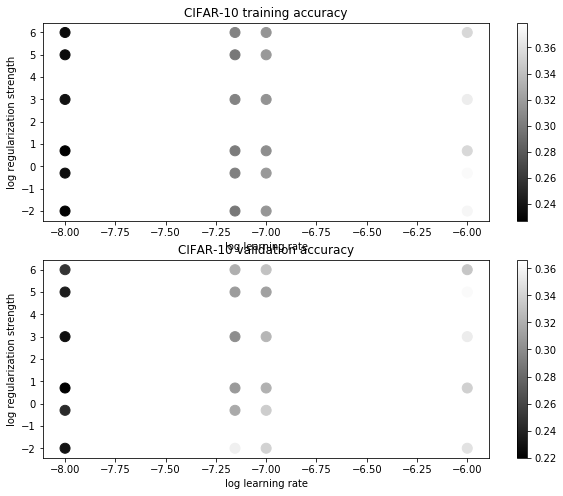

In [28]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [30]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'linear SVM on raw pixels final test set accuracy: %f' % test_accuracy

linear SVM on raw pixels final test set accuracy: 0.343000


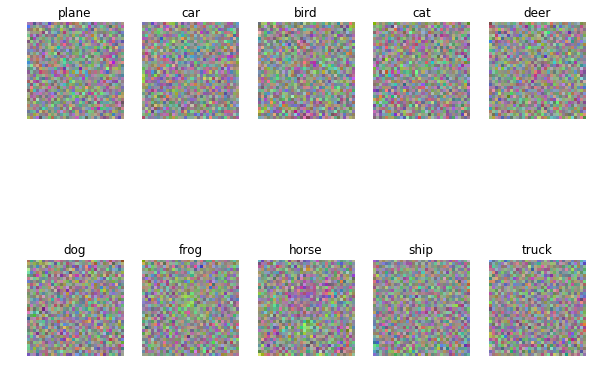

In [31]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
    
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

# Note:
Most of them are not really recognizable. The frog one shows a more pronounced green middle region. The werid colors may be due to the stripped out bias values.

These are the hyperplanes from the gradients trained. Since SVM is a large margin classifier, we shouldn't expect these to be very recognizable. Recall that not any positive response is a perfect positive class because of the delta margin value. The hyperplane of SVM technically allows more variance in testing data precisely because of this more conservative hyperplane.  